# SPIDER 2.0 Experiment
---

### Import and Functions

In [1]:
import sys
import os
import json
import argparse
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import PchipInterpolator


load_dotenv()
sys.path.append(os.path.abspath("..")) 

from MM.model_selector import ModelSelector
from MM.agent.llm import LLMAgent


/home/yosef/miniconda3/envs/mm/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
def load_data(test_path):
    assert test_path.endswith(".jsonl"), f"Invalid test_path, must be a valid jsonl file: {test_path}"
    with open(test_path, "r") as f:
        task_configs = [json.loads(line) for line in f]
    
    return task_configs

In [3]:
def selector_config()->argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=f"Initiate config for Model Selector"
    )

    #General
    parser.add_argument("--n_cluster", type=int, default=5)
    parser.add_argument("--sample_rate", type=float, default=0.06)

    #Thompson
    parser.add_argument("--prior_size", type=int, default=16)

    #Succesive Reject
    parser.add_argument("--eval_size", type=int, default=16)
    parser.add_argument("--strategy", default="vanilla", help="['vanilla', 'halving']")
    

    #UCB
    parser.add_argument("--eval_rate", type=float, default=0.1)
    parser.add_argument("--k_model", type=int, default=3)
    parser.add_argument("--coeff", type=float, default=0.5)
    parser.add_argument("--rounds", type=int, default=10)

    args = parser.parse_known_args()
    return args

In [4]:
def model_config(model:str, cost: float) -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=f"Initiate config for {model}"
    )
    
    #Path settings
    parser.add_argument("--system_prompt_path", help="System prompt file path", default="/home/yosef/ace/mm/MM/agent/prompts/spider_prompt.txt")
    parser.add_argument("--databases_path", help="Databases directory path", default="/home/yosef/ace/mm/MM/dataset/spider/resource/databases")
    parser.add_argument("--documents_path", help="Documents directory path", default="/home/yosef/ace/mm/MM/dataset/spider/resource/documents")
    parser.add_argument("--gold_path", help="Query evaluation path", default="/home/yosef/ace/mm/MM/dataset/spider/gold/exec_result")
    parser.add_argument("--condition_path", help="Evaluation condition path", default="/home/yosef/ace/mm/MM/dataset/spider/gold/spider2snow_eval.jsonl")

    #LLM settings
    parser.add_argument("--model", type=str, default = model)
    parser.add_argument("--cost", type=float, default = cost)
    parser.add_argument("--temperature", type=float, default=0.0)
    parser.add_argument("--top_p", type=float, default=1.0)
    parser.add_argument("--max_new_tokens", type=int, default=4000)
    parser.add_argument("--stop_token", type=str, default=None)
    parser.add_argument("--prompt_strategy", default="spider-agent", 
                       choices=["spider-agent"],
                       help="Prompt building strategy")

    # Execution settings
    parser.add_argument("--api_host", default="localhost", help="API host")
    parser.add_argument("--api_port", default="5000", help="API port")
    parser.add_argument("--max_rounds", type=int, default=10, help="Max conversation rounds")
    parser.add_argument("--num_threads", type=int, default=4, help="Number of threads")
    parser.add_argument("--rollout_number", type=int, default=1, help="Number of rollouts per example")

    # Evaluation settings
    parser.add_argument("--max_query", type=int , default=50000, help="Number of max row")
    parser.add_argument("--env", default="snowflake", help="Environment for SQL excution ")

    args = parser.parse_known_args()
    return args

In [5]:

def plot_pf_sorted(data, filename=None):
    df = pd.DataFrame(data)
    df_sorted = df.sort_values("Cost", ascending=True).reset_index(drop=True)

    frontier_idx = []
    max_score_so_far = -np.inf
    for idx, row in df_sorted.iterrows():
        if row["Score"] > max_score_so_far:
            frontier_idx.append(idx)
            max_score_so_far = row["Score"]
    pf = df_sorted.loc[frontier_idx]

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.set(style="whitegrid", font_scale=1.2)

    if len(pf) >= 2:
        log_c = np.log(pf["Cost"].values)
        scores = pf["Score"].values
        spline = PchipInterpolator(log_c, scores)

        log_xs = np.linspace(log_c.min(), log_c.max(), 300)
        xs = np.exp(log_xs)
        ys = spline(log_xs)

        ax.plot(
            xs, ys,
            color="red", linewidth=1.5, zorder=1, alpha=0.6,
            label="_nolegend_"
        )
    elif len(pf) == 2:
        ax.plot(
            pf["Cost"], pf["Score"],
            color="red", linewidth=1.5, zorder=1, alpha=0.6,
            label="_nolegend_"
        )

    sns.scatterplot(
        x="Cost", y="Score",
        hue="Model",
        palette="tab20",
        data=df_sorted,
        s=120,
        edgecolor="white",
        linewidth=1.2,
        ax=ax,
        legend="full",
        zorder=2
    )

    ax.set_xscale("log")
    cost_ticks = df_sorted["Cost"].unique()
    ax.set_xticks(cost_ticks)
    ax.set_xticklabels([f"{c:g}" for c in cost_ticks])

    ax.set_xlim(0.1, 50)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cost Input and Output ($/1 M Tokens)", fontsize=13)
    ax.set_ylabel("Arena Score", fontsize=13)

    ax.legend(
        title="Model",
        loc="best",
        frameon=True,
        framealpha=0.8
    )

    ax.grid(True, which="both", linestyle="--", linewidth=0.3, alpha=0.25)
    plt.tight_layout()

    if filename:
        fig.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()
    return fig, ax


### Main

In [6]:
import subprocess

subprocess.Popen(
    ["bash", "/home/yosef/ace/mm/experiments/run_server.sh"],
    stdout=None,
    stderr=subprocess.STDOUT
)


<Popen: returncode: None args: ['bash', '/home/yosef/ace/mm/experiments/run_...>

In [7]:
plafortm_conf = selector_config()
configs = [model_config("google/gemini-2.0-flash-001",0.225), model_config("google/gemini-2.5-flash",0.45), model_config("google/gemini-2.5-pro",2.5)]

dataset = load_data(os.path.join(os.path.abspath(".."),"MM/dataset/spider/spider2-snow.jsonl"))
models = list()
for conf in configs:
    models.append(LLMAgent(conf[0]))

selector = ModelSelector( models=models, args=plafortm_conf[0])


/home/yosef/miniconda3/envs/mm/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Cluster sampling

In [10]:
cs_res = selector.cluster_sampling(dataset)
print(cs_res)

[03:59:08] Start Sampling
[04:00:35] Start Evaluating LLMAgent(name=google/gemini-2.0-flash-001)
[04:03:28] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq269 | Not Terminated!
[04:04:40] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq127 | Not Terminated!
[04:06:01] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq215 | Not Terminated!
[04:07:22] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq233 | Not Terminated!
[04:07:49] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq394 | Not Terminated!
[04:08:03] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq181 | Scored :False
[04:08:33] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq073 | Not Terminated!
[04:10:35] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq342 | Not Terminated!
[04:11:16] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq407 | Not Terminated!
[04:12:56] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf

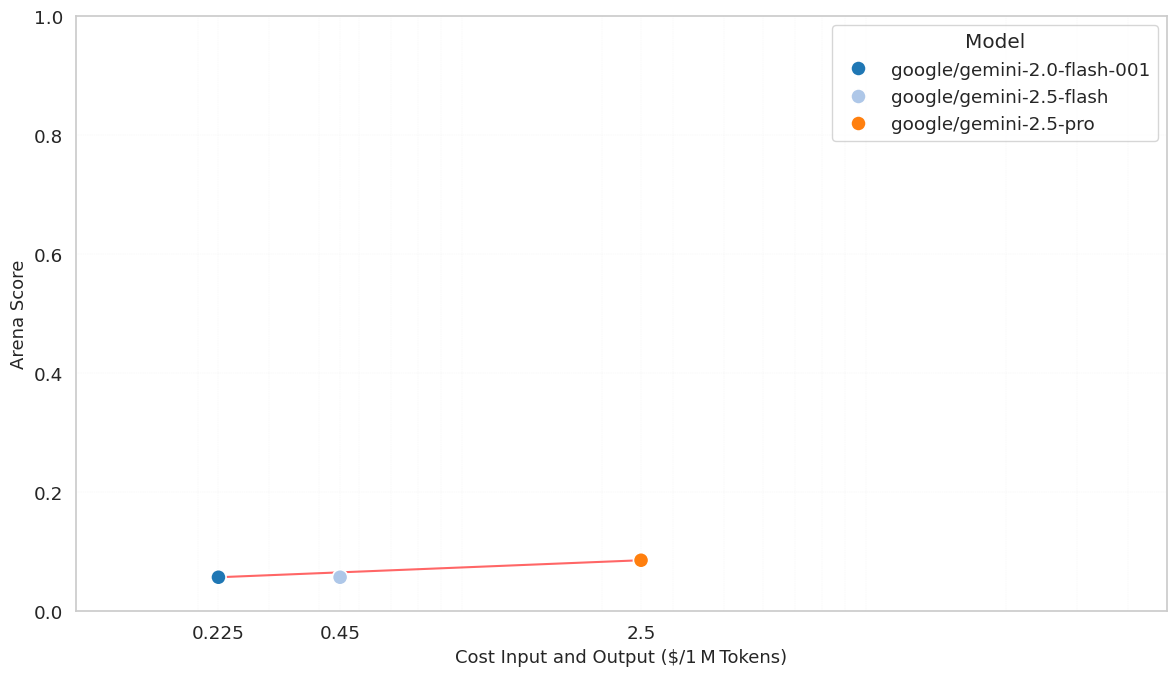

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [11]:
cs_shw = []
for idx,conf in enumerate(configs):
    cs_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":cs_res[idx]
    })

plot_pf_sorted(cs_shw,"cs_spider.png")

### Cluster sampling + Thompson sampling 

In [8]:
csts_res = selector.cluster_sampling_thompson(dataset)
print(csts_res)

[01:38:35] Start Sampling
[01:39:58] Start Computing prior LLMAgent(name=google/gemini-2.0-flash-001)
[01:40:52] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf008 | Not Terminated!
[01:41:50] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq429 | Not Terminated!
[01:42:18] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf009 | Scored :True
[01:42:59] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq170 | Scored :False
[01:43:20] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_ga031 | Scored :False
[01:43:49] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq088 | Not Terminated!
[01:44:19] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_local018 | Scored :False
[01:44:33] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_local133 | Scored :False
[01:45:29] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq350 | Not Terminated!
[01:46:43] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq1

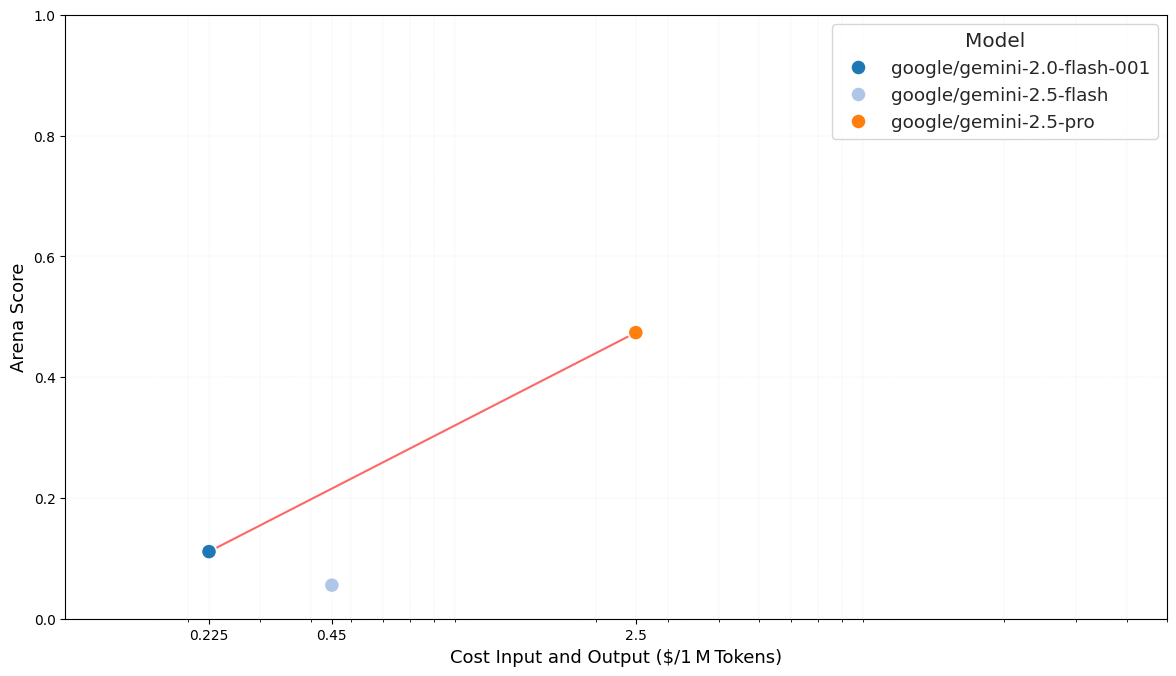

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [9]:
csts_shw = []
for idx,conf in enumerate(configs):
    csts_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":csts_res[idx]
    })

plot_pf_sorted(csts_shw,"csts_spider.png")


### Succesive Reject

In [9]:
sr_res = selector.succesive_reject(dataset)
print(sr_res)

[22:23:38] Start Sampling
[22:25:46] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq268 | Not Terminated!
[22:26:50] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq216 | Not Terminated!
[22:27:31] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq225 | Scored :False
[22:28:10] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq357 | Scored :True
[22:28:23] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq181 | Scored :False
[22:29:03] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq429 | Not Terminated!
[22:29:57] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq334 | Scored :True
[22:30:19] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq088 | Scored :False
[22:31:52] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq089 | Not Terminated!
[22:33:06] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq063 | Not Terminated!
[22:34:07] LLMAgent(name=google/gemini-2.0-flash-001) | 

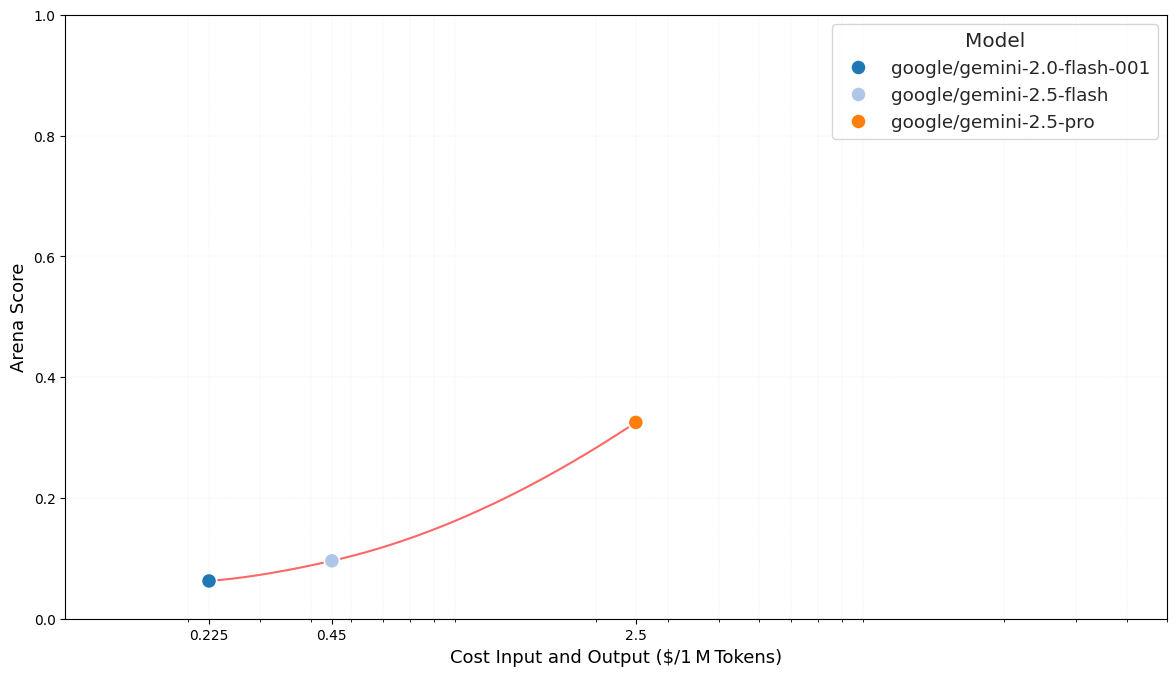

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [10]:
df = pd.DataFrame(sr_res)
df_filled = df.fillna(0)
col_avg = df_filled.mean().tolist()

sr_shw = []
for idx,conf in enumerate(configs):
    sr_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":col_avg[idx]
    })
plot_pf_sorted(sr_shw,"sr_spider.png")


### UCB

In [8]:
ucb_res = selector.ucb(dataset)
print(ucb_res)

[20:37:14] Start Sampling
[20:38:12] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf008 | Not Terminated!
[20:38:54] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq429 | Not Terminated!
[20:40:02] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf009 | Scored :True
[20:40:21] LLMAgent(name=google/gemini-2.5-flash) | Instance: sf_local354 | Not Terminated!
[20:41:02] LLMAgent(name=google/gemini-2.5-flash) | Instance: sf_bq268 | Not Terminated!
[20:43:01] LLMAgent(name=google/gemini-2.5-flash) | Instance: sf_local008 | Not Terminated!
[20:56:39] Failed to get valid LLM response for sf_bq429
[20:56:39] LLMAgent(name=google/gemini-2.5-pro) | Instance: sf_bq429 | Not Terminated!
[21:00:08] LLMAgent(name=google/gemini-2.5-pro) | Instance: sf009 | Scored :True
[21:00:45] LLMAgent(name=google/gemini-2.5-pro) | Instance: sf_bq285 | Scored :False
[21:01:49] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: sf_bq429 | Scored :False
[21:03:13] LLMAgent(name=googl

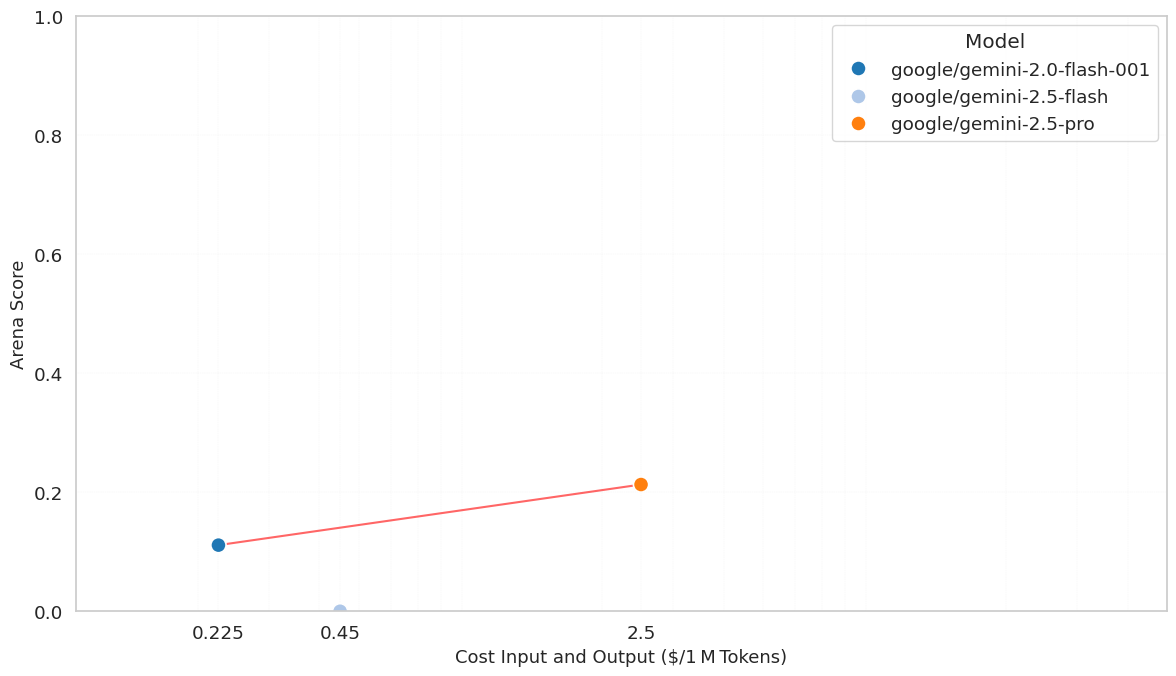

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [21]:
ucb_shw = []
for res in ucb_res:
    ucb_shw.append({
        "Model":configs[res[0]][0].model,
        "Cost": configs[res[0]][0].cost,
        "Score":res[2]
    })
plot_pf_sorted(ucb_shw,"ucb_spider.png")
